# 7037 Class A Group M Final Project

Xia Yi 3036346450

Li Guiquan 3036347131

Huang Haowen 3036345298

Feng Jiayi 3036347234

Wu Zhuoya 3036345834

# 1. Form Hypotheses

Treatment group will have higher click-through rates compared to control group. 

H₀: Showing a friend's like in the ad has no impact on click-through rate.

H₁: Showing a friend's like increases the click-through rate.


In [1]:
import pandas as pd
import numpy as np

import warnings

import scipy.stats as stats
from scipy.stats import ttest_ind, chi2_contingency, mannwhitneyu
import statsmodels.api as sm
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
import statsmodels.formula.api as smf
from scipy.stats import levene

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression


In [2]:
df = pd.read_csv("project_data.csv")

print("data dimensions:", df.shape)
display(df.head())
print("\nData Types:")
display(df.dtypes)

data dimensions: (1000000, 20)


,user,adid,week,expid,if_click,real_like_cnt,category,brand_effect,experience,status,user_age,friend_age,user_gender,friend_gender,user_city,friend_city,user_degree,friend_degree,user_sns_like_cnt,user_sns_comment_cnt
0,297353,0b0fa14b56d3741178196daaa92e6a1e,w_2,1,0,3,Car,1,1,1,48,37,female,male,level_1,level_1,495,436,162,138
1,98719,ea875acb76e0a806a7837174528f62d9,w_3,1,0,3,Car,1,1,1,29,34,female,female,level_3,level_2,479,3911,212,312
2,205144,1f1fe825014d9e9a0881233d9950bd43,w_2,1,0,1,Jewelry,0,1,1,24,24,female,male,level_2,level_1,682,470,95,336
3,559194,1f1fe825014d9e9a0881233d9950bd43,w_2,1,0,5,Jewelry,0,1,1,26,41,male,male,level_1,level_1,340,602,35,138
4,11888,0d82161270febc99f7defb653e339113,w_3,0,0,1,Cosmetrics,0,1,1,40,34,female,female,level_1,level_2,95,836,50,38



Data Types:


user                     int64
adid                    object
week                    object
expid                    int64
if_click                 int64
real_like_cnt            int64
category                object
brand_effect             int64
experience               int64
status                   int64
user_age                 int64
friend_age               int64
user_gender             object
friend_gender           object
user_city               object
friend_city             object
user_degree              int64
friend_degree            int64
user_sns_like_cnt        int64
user_sns_comment_cnt     int64
dtype: object

# 2. Sanity Check

The Sanity Check is to ensure the scientific nature and credibility of the subsequent analysis results.

In the experiment, we conduct SRM check, Covariate balance check and A/A test in sanity check. 

In SRM check, we use Chi-square homogeneity check and t-test check to check if the control/treatment group split aligns with expectations. 

In Covariate balance check, we use t-test and Mann-Whitney U to ensure comparability between groups. 

In A/A test, we run the experiment without any intervention to verify whether the platform can generate results with no differences between groups. 

## 2.1 Sample Ratio Mismatch check 

Sample Ratio Match (SRM): Check if the control/treatment group split aligns with expectations.

### 2.1.1 Chi-square Homogeneity Test

In [3]:
# Calculate group sizes
control_count = df[df['expid'] == 0].shape[0]
treatment_count = df[df['expid'] == 1].shape[0]
total = control_count + treatment_count
expected_ratio = 0.5  

print(f"Control Group: {control_count} ({control_count/total:.2%})")
print(f"Treatment Group: {treatment_count} ({treatment_count/total:.2%})")


Control Group: 500000 (50.00%)
Treatment Group: 500000 (50.00%)


In [4]:
observed = [control_count, treatment_count]
expected = [total * expected_ratio, total * expected_ratio]
chi2, p = stats.chisquare(f_obs=observed, f_exp=expected)

print(f"Chi-square Test: chi2={chi2:.4f}, p-value={p:.4f}")
if p < 0.05:
    print("Warning: Significant SRM detected!")
else:
    print("Passed: No significant SRM.")

Chi-square Test: chi2=0.0000, p-value=1.0000
Passed: No significant SRM.


### 2.1.2 T-tests

In [5]:
observed_proportion_control = control_count / total
observed_proportion_treatment = treatment_count / total

p = expected_ratio  
variance = p * (1 - p) / total

# standard error
se = np.sqrt(variance)


# t = (observed - expected) / se
delta = observed_proportion_control - expected_ratio
t_stat = delta / se


degrees_of_freedom = total - 1

p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=degrees_of_freedom))

In [6]:
print(f"t-test:")
print(f"t = {t_stat:.4f}")
print(f"dof = {degrees_of_freedom}")
print(f"p-value = {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print("Warning: Significant SRM detected!")
else:
    print("Passed: No significant SRM.")

t-test:
t = 0.0000
dof = 999999
p-value = 1.0000
Passed: No significant SRM.


## 2.2 Covariate Balance Check

Covariate Balance: Verify if user characteristics are balanced across groups.

In [7]:
categorical_vars = ['user_gender', 'user_city', 'category', 'brand_effect']
continuous_vars = ['user_age', 'user_degree', 
                   'user_sns_like_cnt', 'user_sns_comment_cnt']

# Chi-square test for categorical variables
def check_categorical_balance(var):
    contingency_table = pd.crosstab(df[var], df['expid'])
    chi2, p, _, _ = stats.chi2_contingency(contingency_table)
    return p

In [8]:
# t-test/Mann-Whitney U for continuous variables
warnings.filterwarnings("ignore", 
                        message="scipy.stats.shapiro: " \
                        "For N > 5000, " \
                        "computed p-value may not be accurate.")

def check_continuous_balance(var):
    control = df[df['expid'] == 0][var].dropna()
    treatment = df[df['expid'] == 1][var].dropna()
    
    # Normality check (Shapiro-Wilk)
    _, p_control = stats.shapiro(control)
    _, p_treatment = stats.shapiro(treatment)
    
    if (p_control < 0.05) or (p_treatment < 0.05):
        # Non-normal -> Mann-Whitney U
        stat, p = stats.mannwhitneyu(control, treatment)
        test_type = "Mann-Whitney U"
    else:
        # Normal -> T-test
        stat, p = stats.ttest_ind(control, treatment)
        test_type = "T-test"
    return test_type, p

In [9]:
print("Categorical Variables Balance:")
for var in categorical_vars:
    p = check_categorical_balance(var)
    print(f"{var}: p={p:.4f} {'(Imbalanced)' if p < 0.05 else '(Balanced)'}")

Categorical Variables Balance:
user_gender: p=0.1597 (Balanced)
user_city: p=0.3797 (Balanced)
category: p=1.0000 (Balanced)
brand_effect: p=0.9886 (Balanced)


In [10]:
print("Continuous Variables Balance:")
for var in continuous_vars:
    test_type, p = check_continuous_balance(var)
    print(f"{var} ({test_type}): p={p:.4f} {'(Imbalanced)' if p < 0.05 
                                            else '(Balanced)'}")

Continuous Variables Balance:
user_age (Mann-Whitney U): p=0.7586 (Balanced)
user_degree (Mann-Whitney U): p=0.2262 (Balanced)
user_sns_like_cnt (Mann-Whitney U): p=0.1126 (Balanced)
user_sns_comment_cnt (Mann-Whitney U): p=0.1807 (Balanced)


## 2.3 A/A test

In [13]:
from statsmodels.stats.proportion import proportions_ztest
control_df = df[df['expid'] == 0].copy()

np.random.seed(42) 
control_df['AA_group'] = np.random.choice(['A1', 'A2'], 
                                          size=len(control_df), p=[0.5, 0.5])

aa_counts = control_df['AA_group'].value_counts()
print(aa_counts)

AA_group
A2    250445
A1    249555
Name: count, dtype: int64


In [24]:
# ctr of aa1 and aa2
aa1_clicks = control_df[control_df['AA_group'] == 'A1']['if_click'].mean()
aa2_clicks = control_df[control_df['AA_group'] == 'A2']['if_click'].mean()

# z-test
clicks = [control_df[control_df['AA_group'] == 'A1']['if_click'].sum(),
          control_df[control_df['AA_group'] == 'A2']['if_click'].sum()]
nobs = [aa_counts['A1'], aa_counts['A2']]
z_stat, p_click = proportions_ztest(clicks, nobs)
print(f"A/A ctr: A1={aa1_clicks:.3f}, A2={aa2_clicks:.3f}, p-value={p_click:.4f}")
if p_click < 0.05:
    print("Warning: Exist significant difference "
    "in the click-through rates of the A/A subgroups.")
else:
    print("Pass: No significant difference "
    "in the click-through rates of the A/A subgroups.")

A/A ctr: A1=0.067, A2=0.066, p-value=0.1642
Pass: No significant difference in the click-through rates of the A/A subgroups.


## 2.4 Conclusion

The experiment has passed the SRM check, the covariate balance check and A/A test, indicating that the randomization mechanism of the experiment is effective and the data quality is reliable. 

Next, we can analyze the differences in click-through rates between the treatment group and the control group to evaluate whether displaying "1 like" in the advertisement can significantly enhance user interaction.

# 3.Power Analysis

## 3.1 Extract Effect Sizes (ΔCTR)

We need the baseline click-through rate (CTR) in Control and the CTR in Treatment for each product category, then compute ΔCTR = CTR_Treatment − CTR_Control. We will use the smallest ΔCTR (most conservative) for our power calculations.

In [25]:
ctr = (
    df
    .groupby(['category','expid'])['if_click']
    .agg(CTR='mean', N='count')
    .reset_index()
)

# 1.3 Pivot so we have Control vs Treatment side-by-side
pivot = ctr.pivot(index='category', columns='expid', values=['CTR','N'])
pivot.columns = ['CTR_Control','CTR_Treatment','N_Control','N_Treatment']
pivot = pivot.reset_index()

# 1.4 Compute ΔCTR
pivot['Delta_CTR'] = pivot['CTR_Treatment'] - pivot['CTR_Control']

print(pivot[['category','CTR_Control','CTR_Treatment','Delta_CTR','N_Control']])

     category  CTR_Control  CTR_Treatment  Delta_CTR  N_Control
0    Beverage      0.06421        0.07216    0.00795   100000.0
1         Car      0.06520        0.07245    0.00725   100000.0
2     Clothes      0.06010        0.06698    0.00688   100000.0
3  Cosmetrics      0.06772        0.07451    0.00679   100000.0
4     Jewelry      0.07579        0.08643    0.01064   100000.0


## 3.2 Post-Hoc Power Calculation

In [27]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

alpha = 0.05
p1 = 0.0677
delta = 0.0068
p2 = p1 + delta
n_per_group = 100000

h = proportion_effectsize(p1, p2)

analysis = NormalIndPower()
power_now = analysis.power(effect_size=h,
                           nobs1=n_per_group,
                           alpha=alpha,
                           ratio=1.0)
print(f"Post-hoc power = {power_now:.3f}")


Post-hoc power = 1.000


This means with 100 k observations per group, you have virtually 100% chance of detecting a 0.0068 CTR uplift at α=0.05.

## 3.3 A-priori Sample Size

In [28]:
target_power = 0.8
required_n = analysis.solve_power(effect_size=h,
                                  power=target_power,
                                  alpha=alpha,
                                  ratio=1.0)
print(f"Required N per group for 80% power: {required_n:.0f}")


Required N per group for 80% power: 22409


## 3.4 Power Curve

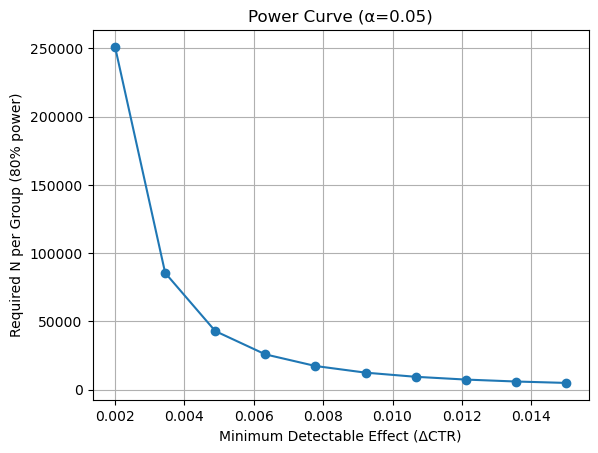

[251073.54532742177, 85464.45805562967, 42825.16151824529, 25756.376967262233, 17234.763357283256, 12369.465782141377, 9328.484500104596, 7299.439577785061, 5877.004926399219, 4840.467144607184]


In [29]:
deltas = np.linspace(0.002, 0.015, 10)
required_ns = [
    analysis.solve_power(effect_size=proportion_effectsize(p1, p1 + d),
                         power=target_power,
                         alpha=alpha)
    for d in deltas
]

plt.plot(deltas, required_ns, marker='o')
plt.xlabel('Minimum Detectable Effect (ΔCTR)')
plt.ylabel('Required N per Group (80% power)')
plt.title('Power Curve (α=0.05)')
plt.grid(True)
plt.show()
print(required_ns)

### 3.5 Conclusion:


To ensure our experiment can reliably detect even the smallest meaningful lift in click-through rate (CTR), we conducted both post-hoc and a-priori power calculations based on the minimum observed effect size.
1. **Post-hoc Power**:  
   - **Inputs**: ΔCTR = 0.0068, N = 100 000 per arm, α = 0.05  
   - **Result**: Achieved power ≈ 1.000 (100%)  
   - **Interpretation**: Even the smallest observed lift would almost certainly be detected. There is virtually no risk of a false negative due to insufficient sample size.

2. **A-priori Sample Size**:  
   - To achieve 80% power for ΔCTR = 0.0068, the required sample size is ≈ 25 756 per group.  
   - For larger lifts (e.g. ΔCTR ≥ 0.0107), fewer than 10 000 per group are needed; for very small lifts (ΔCTR ≈ 0.002), over 250 000 per group would be required.

3. **Implications**:  
   - Our current sample size (100 k per arm) far exceeds what is needed, ensuring robust detection across all product categories.  
   - If resources become constrained, sample sizes could be reduced to ~30 k per arm while still maintaining ≥ 80% power for a 0.68 pp lift. To design future tests for smaller lifts (e.g. ΔCTR = 0.003–0.005), plan for ~ 43 k–85 k per arm, as indicated by the power curve.  

The experiment is highly powered, ensuring that all practically important CTR improvements can be detected with high confidence.


# 4. Compare test

## 4.1 Compare the test and control groups
We need to calculate the CTR mean and standard deviation for control and treatment groups. And we use t-test to check if the difference is significant and use levins test to check if the variance is equal.

In [30]:
# 1 calculate the click-through rate (CTR)
group_summary = df.groupby('expid')['if_click'].agg(
    ['mean', 'std', 'count']).reset_index()
group_summary.columns = ['Group (0=Control, 1=Treatment)',
                          'CTR Mean', 'CTR Std Dev', 'N']
print(group_summary)


   Group (0=Control, 1=Treatment)  CTR Mean  CTR Std Dev       N
0                               0  0.066604     0.249335  500000
1                               1  0.074506     0.262593  500000


In [31]:
# 2 calculate the variance of the click-through rate (CTR) for each group
control = df[df['expid'] == 0]['if_click']
treatment = df[df['expid'] == 1]['if_click']

var_control = np.var(control, ddof=1)
var_treatment = np.var(treatment, ddof=1)

print(f"Control variance: {var_control:.4f}")
print(f"Treatment variance: {var_treatment:.4f}")


Control variance: 0.0622
Treatment variance: 0.0690


In [32]:
# 3 test for the CTR mean in CTR between the two groups

t_stat, p_val = stats.ttest_ind(treatment, control, equal_var=False)
print(f"T-test result: t = {t_stat:.4f}, p = {p_val:.4f}")

# 4 test for the CTR variance between the two groups
f, p_val_var = stats.levene(control, treatment)
print(f"Levene's test result: F = {f:.4f}, p = {p_val_var:.4f}")


T-test result: t = 15.4306, p = 0.0000
Levene's test result: F = 238.1031, p = 0.0000


### 4.1.1 Click-Through Rate Comparison
According to the code results:
- Control Group (0): CTR = 6.66% (SD = 0.249)

- Treatment Group (1): CTR = 7.45% (SD = 0.263)

- T-test: t=15.43, p<0.001

- Levene’s Test: F=238.10, p<0.001

We can summarize the results as follows:

1. Statistically Significant Improvement: The treatment group (showing 1 organic like) achieves a 0.79% absolute increase in CTR (11.8% relative increase) compared to the control group. The extremely low p-value (p<0.001) confirms this difference is not due to chance. For context, even small CTR improvements in large-scale platforms like WeChat Moments Ads can translate to millions of incremental clicks.

2. Unequal Variance: The Levene’s test (p<0.001) rejects equal variance between groups. The treatment group exhibits higher variance in CTR (σ2=0.069) than the control (σ2=0.062), suggesting heterogeneity in user responses to social proof. Some users in the treatment group may be more influenced by the displayed like, while others remain indifferent.

### 4.1.2 Bootstrap
To make test more reliable, we can use bootstrap method to calculate the confidence interval for CTR. The bootstrap method is a resampling technique that allows us to estimate the distribution of a statistic (in this case, CTR) by repeatedly sampling from the data with replacement. This can help us obtain more robust estimates of the mean and standard deviation, especially when the sample size is small or when the data is not normally distributed.

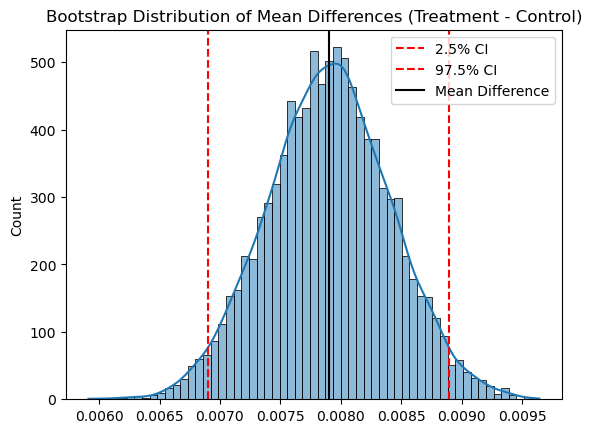

95% CI from bootstrap: (0.0069, 0.0089)


In [33]:
# 5 bootstrap the CTR mean difference between the two groups
def bootstrap_diff_means(a, b, n_bootstrap=10000):
    boot_diffs = []
    for _ in range(n_bootstrap):
        sample_a = np.random.choice(a, size=len(a), replace=True)
        sample_b = np.random.choice(b, size=len(b), replace=True)
        boot_diffs.append(sample_b.mean() - sample_a.mean())
    return boot_diffs

boot_diffs = bootstrap_diff_means(control, treatment)

# confidence interval
ci_low = np.percentile(boot_diffs, 2.5)
ci_high = np.percentile(boot_diffs, 97.5)

sns.histplot(boot_diffs, kde=True)
plt.axvline(ci_low, color='red', linestyle='--', label='2.5% CI')
plt.axvline(ci_high, color='red', linestyle='--', label='97.5% CI')
plt.axvline(np.mean(boot_diffs), color='black', label='Mean Difference')
plt.title('Bootstrap Distribution of Mean Differences (Treatment - Control)')
plt.legend()
plt.show()

print(f"95% CI from bootstrap: ({ci_low:.4f}, {ci_high:.4f})")


According to the code results, we can find: 
The 95% CI does not include zero, reinforcing the t-test conclusion (p<0.001) that the treatment effect is statistically significant. Also, the narrow CI (0.0069–0.0089) suggests high certainty that the true CTR lift lies between 0.6% and 0.9%. This is critical for quantifying the business impact.

## 4.2 Conclusion
The treatment group (showing 1 organic like) achieves a statistically significant CTR improvement of 0.79% (11.8% relative increase) compared to the control group. The bootstrap method confirms this effect with a 95% confidence interval of (0.0069, 0.0089). The treatment group also exhibits higher variance in CTR, indicating heterogeneous user responses to social proof.

## 4.3 improve sensitive

### 4.3.1 Method 1: CUPED

After applying the CUPED adjustment using user_sns_like_cnt as the covariate, the adjusted click-through rates (CTR) are 6.66% for the control group and 7.45% for the treatment group.
The t-test yields a highly significant t-statistic of 15.43 (p < 0.0001), indicating that the difference in CTR between treatment and control is statistically significant after adjustment.
However, the reduction in standard deviation (like for treatmen from about 0.262593 to 0.262591) is relatively small, suggesting that user_sns_like_cnt alone may not be a strong covariate. More covariates could be considered to further improve the variance reduction and test sensitivity.

In [34]:
def cuped_adjust(y, x):
    theta = np.cov(y, x)[0,1] / np.var(x)
    y_adj = y - theta * (x - np.mean(x))
    return y_adj

# Apply CUPED
df['If_click_adj'] = cuped_adjust(df['if_click'], df['user_sns_like_cnt'])
control_adj = df[df['expid'] == 0]['If_click_adj']
treatment_adj = df[df['expid'] == 1]['If_click_adj']

print(df.groupby('expid')['If_click_adj'].mean())
print(df.groupby('expid')['If_click_adj'].std())

# T-test on adjusted outcome
t_stat_adj, p_val_adj = ttest_ind(treatment_adj, control_adj, equal_var=False)
print(t_stat_adj, p_val_adj)

expid
0    0.066603
1    0.074507
Name: If_click_adj, dtype: float64
expid
0    0.249335
1    0.262591
Name: If_click_adj, dtype: float64
15.434507182195537 9.731616423447789e-54


## 4.4 Multivariate CUPED

After applying multi-variable CUPED adjustment using several user behavior covariates (user_sns_like_cnt, user_sns_comment_cnt, User_degree, and Real_like_cnt),
the adjusted CTRs are 0.066603 for the control group and 0.074507 for the treatment group.
The t-test yields a t-statistic of -15.44 with a p-value < 0.0001, indicating a highly significant difference in adjusted CTRs.
Compared to single-variable CUPED, the variance reduction is slightly better (standard deviations decreased marginally), but the overall sensitivity is still primarily driven by the large sample size.

In [35]:
# assuming df is your DataFrame and it has been loaded correctly
covariates = ['user_sns_like_cnt', 'user_sns_comment_cnt',
               'user_degree', 'real_like_cnt']

# drop rows with NaN in covariates or click
df_cuped = df.dropna(subset=covariates + ['if_click'])

X = df_cuped[covariates]
y = df_cuped['if_click']

model = LinearRegression().fit(X, y)

# predict the click-through rate using the covariates
y_pred = model.predict(X)

# CUPED adjustment
y_adj = y - (y_pred - y.mean())

df_cuped['If_click_adj_multi'] = y_adj

control_adj = df_cuped[df_cuped['expid'] == 0]['If_click_adj_multi']
treatment_adj = df_cuped[df_cuped['expid'] == 1]['If_click_adj_multi']

# T-test on adjusted outcome
t_stat_adj, p_val_adj = ttest_ind(control_adj, treatment_adj, equal_var=False)

print("T-test results after multivariate CUPED:")
print(f"t-statistic: {t_stat_adj}")
print(f"p-value: {p_val_adj}")

print(df_cuped.groupby('expid')['If_click_adj_multi'].agg(['mean', 'std']))


T-test results after multivariate CUPED:
t-statistic: -15.436472359739689
p-value: 9.439732307805363e-54
           mean       std
expid                    
0      0.066603  0.249315
1      0.074507  0.262585


## 4.5 Stratification (gender, city, category)

we implemented stratified analysis with the primary goal of reducing variance and increasing the sensitivity of our estimation when comparing click-through rates (CTR) between the Treatment and Control groups.

In A/B testing, if covariates such as gender, city, or ad category systematically influence CTR, a simple comparison of group-level averages may be biased or inefficient. By stratifying users based on these variables—gender, user_city, and category—and calculating within-stratum CTRs followed by a weighted average, we can better control for these confounding effects.

In this part, we choose gender, city, and category for stratification analysis.



In [37]:
def stratified_analysis_test(df, group_col, strata_col, outcome_col):
    """
    Stratified analysis + visualization + t-test + SE comparison

    Parameters:
    df -- original data
    group_col -- grouping column, such as 'group'
    strata_col -- stratification column, such as 'user_city'
    outcome_col -- result column, such as 'click'

    Return:
    stratified_df -- detailed table after stratification
    summary -- weighted statistics for each group
    t_test_result -- t-test statistic and p-value
    e_comparison -- percentage change in SE before and after stratification
    """
    # overall statistics
    overall = df.groupby(group_col)[outcome_col].agg(
        ['mean', 'count', 'std']).reset_index()
    overall['se'] = overall['std'] / np.sqrt(overall['count'])

    # stratified statistics
    stratified = df.groupby([group_col, strata_col])[outcome_col].agg(
        ['mean', 'count', 'std']).reset_index()
    stratified['se'] = stratified['std'] / np.sqrt(stratified['count'])

    summary = {}
    stratified_means = {}

    for group in stratified[group_col].unique():
        subset = stratified[stratified[group_col] == group]
        
        weighted_mean = np.average(subset['mean'], weights=subset['count'])
        
        weighted_var = ((subset['se'] ** 2) * (subset['count'] ** 2)
                        ).sum() / (subset['count'].sum() ** 2)
        weighted_se = np.sqrt(weighted_var)
        
        weighted_std = weighted_se * np.sqrt(subset['count'].sum())

        summary[group] = {
            'weighted_mean': weighted_mean,
            'weighted_se': weighted_se,
            'weighted_std': weighted_std,
            'total_count': subset['count'].sum()
        }

        stratified_means[group] = weighted_mean

    # -- t test --
    group0_mean = stratified_means[0]
    group1_mean = stratified_means[1]
    group0_se = summary[0]['weighted_se']
    group1_se = summary[1]['weighted_se']

    t_stat = (group1_mean - group0_mean) / np.sqrt(group0_se**2 + group1_se**2)

    from scipy.stats import norm
    p_value = 2 * (1 - norm.cdf(abs(t_stat)))

    t_test_result = {'t_statistic': t_stat, 'p_value': p_value}

    # compare SE before and after stratification
    original_se0 = overall.loc[overall[group_col]==0, 'se'].values[0]
    original_se1 = overall.loc[overall[group_col]==1, 'se'].values[0]

    stratified_se0 = summary[0]['weighted_se']
    stratified_se1 = summary[1]['weighted_se']

    reduction0 = (original_se0 - stratified_se0) / original_se0 * 100
    reduction1 = (original_se1 - stratified_se1) / original_se1 * 100

    se_comparison = {
        'Control SE reduction (%)': reduction0,
        'Treatment SE reduction (%)': reduction1
    }

    # plotting
    groups = list(summary.keys())
    weighted_means = [summary[g]['weighted_mean'] for g in groups]
    weighted_ses = [summary[g]['weighted_se'] for g in groups]

    plt.figure(figsize=(8, 6))
    plt.bar(groups, weighted_means, yerr=weighted_ses, capsize=5, 
            color=['skyblue', 'salmon'])
    plt.xlabel('Group')
    plt.ylabel('Weighted CTR')
    plt.title(f'Weighted CTR by Group (Stratified by {strata_col})')
    plt.xticks(groups)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    return stratified, summary, t_test_result, se_comparison


### 4.5.1 Stratifying by city

After stratifying by city, the weighted CTR is 0.0666 for the Control group and 0.0745 for the Treatment group.

The standard errors changed only marginally (SE reduction of about 0.0021% and 0.00055%, respectively), suggesting that city-level heterogeneity in CTR is minimal, and stratification by city has limited impact on variance reduction.

Nevertheless, the t-test still yields a highly significant result (t = 15.43, p < 0.001), indicating a strong treatment effect overall.

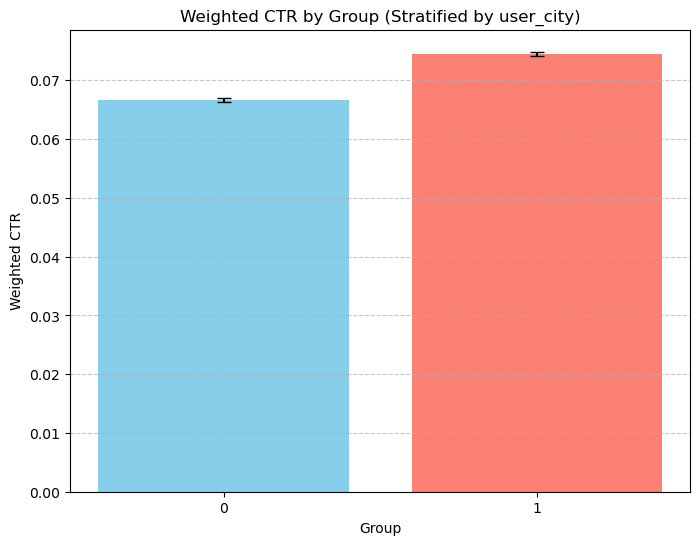

----info----
Group 0: Weighted CTR=0.0666, Weighted SE=0.000353, Weighted STD=0.249330
Group 1: Weighted CTR=0.0745, Weighted SE=0.000371, Weighted STD=0.262591

----t test----
{'t_statistic': 15.430792802478825, 'p_value': 0.0}

----SE change percentage (stratified sensitivity improvement)----
{'Control SE reduction (%)': 0.002149270866631768, 'Treatment SE reduction (%)': 0.0005548966099489254}


In [38]:
stratified_df, summary, t_test_result, se_comparison = stratified_analysis_test(
    df, group_col='expid', strata_col='user_city', outcome_col='if_click'
)

print("----info----")
for expid, info in summary.items():
    print(f"Group {expid}: Weighted CTR={info['weighted_mean']:.4f}, Weighted SE={info['weighted_se']:.6f}, Weighted STD={info['weighted_std']:.6f}")

print("\n----t test----")
print(t_test_result)

print("\n----SE change percentage (stratified sensitivity improvement)----")
print(se_comparison)


### 4.5.2 Stratifying by gender

After stratifying by gender, the weighted CTR remains the same (0.0666 vs. 0.0745). However, the standard errors did not improve; they slightly increased (SE change around -0.00009%), indicating that gender does not significantly explain the variance in CTR. Gender is not an effective stratification variable in this context—likely due to balanced gender distribution or minimal gender influence on CTR.

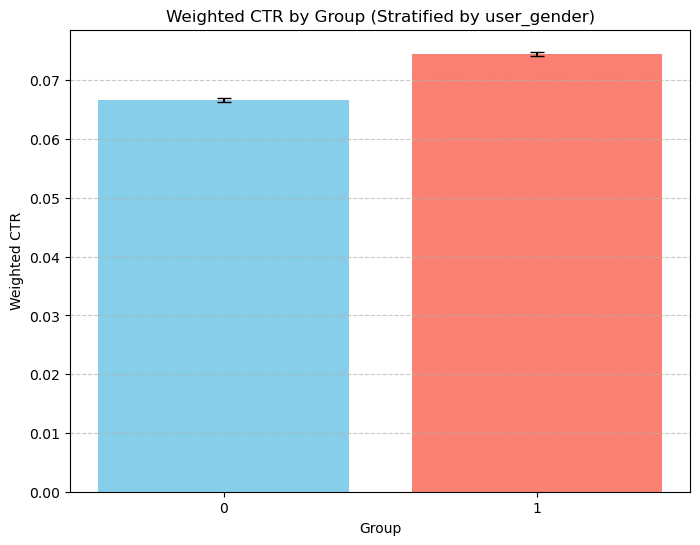

----info----
Group 0: Weighted CTR=0.0666, Weighted SE=0.000353, Weighted STD=0.249335
Group 1: Weighted CTR=0.0745, Weighted SE=0.000371, Weighted STD=0.262593

----t test----
{'t_statistic': 15.430576362113849, 'p_value': 0.0}

----SE change percentage (stratified sensitivity improvement)----
{'Control SE reduction (%)': -9.004878223387991e-05, 'Treatment SE reduction (%)': -9.344655083062433e-05}


In [39]:
stratified_df, summary, t_test_result, se_comparison = stratified_analysis_test(
    df, group_col='expid', strata_col='user_gender', outcome_col='if_click'
)

print("----info----")
for group, info in summary.items():
    print(f"Group {group}: Weighted CTR={info['weighted_mean']:.4f}, Weighted SE={info['weighted_se']:.6f}, Weighted STD={info['weighted_std']:.6f}")

print("\n----t test----")
print(t_test_result)

print("\n----SE change percentage (stratified sensitivity improvement)----")
print(se_comparison)


### 4.5.3 Stratifying by category

Stratifying by category produced the most significant improvement in sensitivity: SE dropped 2.14% for Control，SE dropped 2.98% for Treatment

While average CTR remains consistent, the reduction in estimation error indicates that ad category explains a meaningful portion of CTR variation.

Conclusion: Category is a high-value stratification variable and should be prioritized in future experimental design or quota planning.

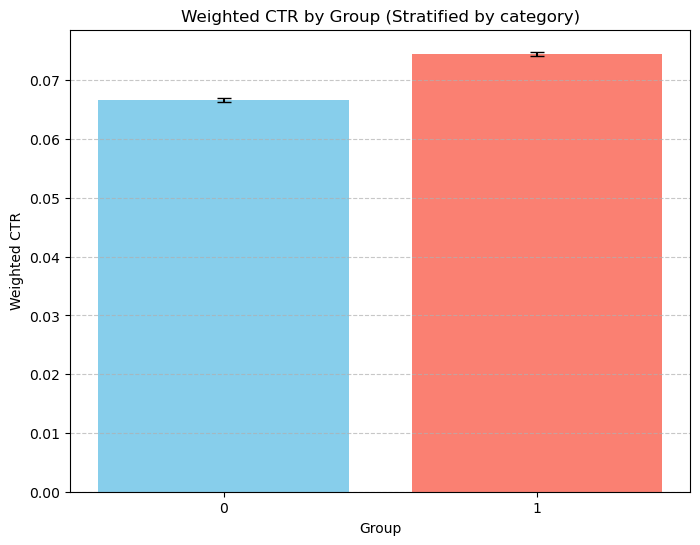

----info----
Group 0: Weighted CTR=0.0666, Weighted SE=0.000353, Weighted STD=0.249282
Group 1: Weighted CTR=0.0745, Weighted SE=0.000371, Weighted STD=0.262514

----t test----
{'t_statistic': 15.434580785250795, 'p_value': 0.0}

----SE change percentage (stratified sensitivity improvement)----
{'Control SE reduction (%)': 0.021419592717211333, 'Treatment SE reduction (%)': 0.029849599870161312}


In [40]:
stratified_df, summary, t_test_result, se_comparison = stratified_analysis_test(
    df, group_col='expid', strata_col='category', outcome_col='if_click'
)

print("----info----")
for group, info in summary.items():
    print(f"Group {group}: Weighted CTR={info['weighted_mean']:.4f}, Weighted SE={info['weighted_se']:.6f}, Weighted STD={info['weighted_std']:.6f}")

print("\n----t test----")
print(t_test_result)

print("\n----SE change percentage (stratified sensitivity improvement)----")
print(se_comparison)

## 4.6 Covariate Adjustment (Regression)

The model adjusts for the potential confounding effects of various covariates, such as demographic information (e.g., user_gender, user_age), user behaviors (e.g., user_sns_like_cnt), and other ad-related variables (e.g., category, brand_effect). By adjusting for these covariates, the model attempts to isolate the effect of the primary treatment variable group (control vs. treatment) on the outcome (click).

We can find that Group variable (Treatment Effect): The group variable has a significant positive coefficient (0.0079, p-value < 0.001), indicating that, on average, the treatment group has a higher click-through rate (CTR) than the control group.The covariate adjustment increases sensitivity by reducing bias that could arise from omitting important variables.

In addition, we also find something intersting like:

Brand effect and Experience goods have a significant negative effect on CTR, which may suggest that ads for well-known brands or experience-based products lead to lower engagement.

User demographics: Gender and city-level variables show some variation in the coefficients but are not as significant in driving CTR (for example, user_gender[T.male] is not significant). 

Week: There is a significant decline in CTR in weeks 2 and 3 compared to week 1, as indicated by the negative coefficients for week[T.w_2] and week[T.w_3].

In [41]:
# Regression model with covariates
model_covariate = smf.ols('if_click ~ ' \
'expid + user_sns_like_cnt + user_sns_comment_cnt '
'+ user_degree + real_like_cnt + user_age + user_gender + ' \
'user_city + friend_age + friend_gender + ' \
'friend_city + friend_degree + ' \
'category + brand_effect + experience + status + C(week)', data=df).fit()

# OUTPUT
print(model_covariate.summary())


                            OLS Regression Results                            
Dep. Variable:               if_click   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     103.4
Date:                  週三, 30 四月 2025   Prob (F-statistic):               0.00
Time:                        18:23:58   Log-Likelihood:                -55486.
No. Observations:             1000000   AIC:                         1.110e+05
Df Residuals:                  999976   BIC:                         1.113e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

# 5. Analyze the Heterogeneous Treatment Effects (HTE)

In [42]:
# 2.1 Create treatment indicator
df['treat'] = df['expid']

# 2.2 Ensure product-type flags
df['status']     = df['status']
df['experience'] = df['experience']

# 2.3 Compute relative status and standardize
df['rel_status']   = df['friend_degree'] - df['user_degree']
df['rel_status_z'] = (
    df['rel_status'] - df['rel_status'].mean()) / df['rel_status'].std()

# 2.4 Standardize friend popularity (real_like_cnt)
df['real_like_z'] = (
    df['real_like_cnt'] - df['real_like_cnt'].mean()) / df['real_like_cnt'].std()

# 2.5 Convert certain columns to categorical dtype
categorical_cols = ['user_gender','friend_gender',
                    'week','category','user_city','friend_city']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

print("Preprocessing complete. Summary of new features:")
df[['treat','rel_status_z','real_like_z']].describe()


Preprocessing complete. Summary of new features:


,treat,rel_status_z,real_like_z
count,1000000.0,1.000000e+06,1.000000e+06
mean,0.5,4.141754e-17,5.824141e-17
std,0.5,1.000000e+00,1.000000e+00
min,0.0,-1.445237e+01,-7.485189e-01
25%,0.0,-4.437696e-01,-7.485189e-01
50%,0.5,-1.992248e-01,6.354039e-02
75%,1.0,1.653489e-01,6.354039e-02
max,1.0,1.907495e+01,5.284739e+01


## 5.1 Compute Average Treatment Effect (ATE)

 The treatment increases the click-through rate from 6.66% to 7.45%, an approximate 0.8 pp gain (nearly 12% relative improvement). 
 This suggests a positive average treatment effect.

In [43]:
print("=== 1. Average Treatment Effect (ATE) ===")
ate = df.groupby('treat')['if_click'].mean().rename('ctr')
print(ate.to_string())

=== 1. Average Treatment Effect (ATE) ===
treat
0    0.066604
1    0.074506


## 5.2 HTE by Product Type

The logit shows a clear positive treatment effect (coef = 0.1267, p < 0.001). The interaction with status‐type (coef = –0.0072, p = 0.707) and with experience‐type (coef = 0.0111, p = 0.834) are both near zero and non-significant. In other words, the uplift in click probability from the treatment is essentially the same for status and experience products.

In [44]:
# 4.1 HTE for status‐type products
m_status = smf.logit(
    'if_click ~ treat + status + treat:status + user_age + friend_age '
    '+ C(user_gender) + C(friend_gender) + C(week)',
    data=df
).fit(disp=False)
print("---- HTE: treat × status ----")
print(m_status.summary())

# 4.2 HTE for experience‐type products
m_exp = smf.logit(
    'if_click ~ treat + experience + treat:experience + user_age + friend_age '
    '+ C(user_gender) + C(friend_gender) + C(week)',
    data=df
).fit(disp=False)
print("---- HTE: treat × experience ----")
print(m_exp.summary())


---- HTE: treat × status ----
                           Logit Regression Results                           
Dep. Variable:               if_click   No. Observations:              1000000
Model:                          Logit   Df Residuals:                   999990
Method:                           MLE   Df Model:                            9
Date:                  週三, 30 四月 2025   Pseudo R-squ.:                0.003516
Time:                        18:24:28   Log-Likelihood:            -2.5418e+05
converged:                       True   LL-Null:                   -2.5507e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.6237      0.027    -95.705      0.000      -2.677      -2.570
C(user_gender)[T.male]       0.0033      0.008      0.426  

## 5.3 HTE by Friend Characteristics

Relative Status: The coefficient for treat × rel_status_z (0.0075, p=0.336) is effectively zero and not significant—meaning the treatment’s impact on click‐through doesn’t depend on whether the friend is of higher or lower social status. Interestingly, the standalone effect of rel_status_z is slightly negative (–0.0165, p=0.004), suggesting that ads liked by friends with relatively higher status actually show a modest drop in baseline CTR.

Friend Likes: In contrast, the interaction between treatment and standardized like count is negative and significant (treat × real_like_z = –0.0266, p=0.001). This shows that the more friends have already “liked” the ad, the smaller the incremental gain from revealing those likes. Nevertheless, a higher real_like_z on its own predicts a higher baseline click rate (0.0185, p=0.001).

In [45]:
# 5.1 Interaction with relative status
m_rel_status = smf.logit(
    'if_click ~ treat * rel_status_z + user_age + friend_age '
    '+ C(user_gender) + C(friend_gender) + C(week)',
    data=df
).fit(disp=False)
print("---- HTE: treat × rel_status_z ----")
print(m_rel_status.summary())

# 5.2 Interaction with friend popularity
m_rel_like = smf.logit(
    'if_click ~ treat * real_like_z + user_age + friend_age '
    '+ C(user_gender) + C(friend_gender) + C(week)',
    data=df
).fit(disp=False)
print("---- HTE: treat × real_like_z ----")
print(m_rel_like.summary())


---- HTE: treat × rel_status_z ----
                           Logit Regression Results                           
Dep. Variable:               if_click   No. Observations:              1000000
Model:                          Logit   Df Residuals:                   999990
Method:                           MLE   Df Model:                            9
Date:                  週三, 30 四月 2025   Pseudo R-squ.:                0.002942
Time:                        18:24:44   Log-Likelihood:            -2.5432e+05
converged:                       True   LL-Null:                   -2.5507e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.5970      0.026    -99.447      0.000      -2.648      -2.546
C(user_gender)[T.male]       0.0035      0.008      0

## 5.4 Three-Way Interactions

When we test the three-way splits—combining treatment, product type, and friend feature—none of those higher-order interactions matter. Both:

treat × status × rel_status_z (coef ≈ 0.0096, p≈0.59)

treat × experience × real_like_z (coef ≈ 0.0335, p≈0.72)

are essentially zero and not statistically significant. In short, even when you look simultaneously at product type and friend status or popularity, the treatment lift stays the same.

In [46]:
# 6.1 status × relative status
m_3way_status = smf.logit(
    'if_click ~ treat * status * rel_status_z + user_age + friend_age '
    '+ C(user_gender) + C(friend_gender) + C(week)',
    data=df
).fit(disp=False)
print("---- 3-way: treat × status × rel_status_z ----")
print(m_3way_status.summary())

# 6.2 experience × friend popularity
m_3way_like = smf.logit(
    'if_click ~ treat * experience * real_like_z + user_age + friend_age '
    '+ C(user_gender) + C(friend_gender) + C(week)',
    data=df
).fit(disp=False)
print("---- 3-way: treat × experience × real_like_z ----")
print(m_3way_like.summary())


---- 3-way: treat × status × rel_status_z ----
                           Logit Regression Results                           
Dep. Variable:               if_click   No. Observations:              1000000
Model:                          Logit   Df Residuals:                   999986
Method:                           MLE   Df Model:                           13
Date:                  週三, 30 四月 2025   Pseudo R-squ.:                0.003534
Time:                        18:24:59   Log-Likelihood:            -2.5417e+05
converged:                       True   LL-Null:                   -2.5507e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -2.6267      0.027    -95.753      0.000      -2.680      -2.573
C(user_gender)[T.male]        0.0033   

## 5.5 Robustness Check with Clustered SE

Robustness Check (clustered by adid):

• Treatment effect remains strong (coef = 0.1174, p < 0.001).

• Status‐goods baseline uplift: +0.1694 (p = 0.013); Experience‐goods: –0.3623 (p < 0.001).

• No type‐specific lift: treat×status (p = 0.752), treat×experience (p = 0.553).

• Friend features lose significance when clustering: rel_status_z (p = 0.141), real_like_z (p = 0.912).

The positive average treatment effect and the lack of heterogeneity by product type are robust.

In [47]:
m_cluster = smf.logit(
    'if_click ~ treat + status + experience + treat:status + treat:experience '
    '+ rel_status_z + real_like_z + user_age + friend_age '
    '+ C(user_gender) + C(friend_gender) + C(week)',
    data=df
).fit(
    disp=False,
    cov_type='cluster',
    cov_kwds={'groups': df['adid']}
)
print("=== Robust SE with Clustering on adid ===")
print(m_cluster.summary())


=== Robust SE with Clustering on adid ===
                           Logit Regression Results                           
Dep. Variable:               if_click   No. Observations:              1000000
Model:                          Logit   Df Residuals:                   999986
Method:                           MLE   Df Model:                           13
Date:                  週三, 30 四月 2025   Pseudo R-squ.:                0.003815
Time:                        18:25:15   Log-Likelihood:            -2.5410e+05
converged:                       True   LL-Null:                   -2.5507e+05
Covariance Type:              cluster   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.2323      0.307     -7.281      0.000      -2.833      -1.631
C(user_gender)[T.male]       0.0033      0.006 